## Bengali.AI Grapheme Classification BanglaNet(keras)

Hello folks,

Welcome to the classification problem regarding bangla grapheme. We are very happy to participate in this competition having a vision to classify the bangla handwritten graphemes. In this classification issue, we have implemented a number of serial non-linear layers as encoder as well as corresponding set of decoders. This encode-decoder algorithm works as a pixelwise classifier. 

To implement, we use Keras, tensorflow as our base to create the model. We did the exploratory data analysis to obtain the unique labels of three variables() given by the dataset. We would like to thanks to the following links

1. Vijay Badrinarayanan, Ankur Handa and Roberto Cipolla "SegNet: A Deep Convolutional Encoder-Decoder Architecture for Robust Semantic Pixel-Wise Labelling." arXiv preprint arXiv:1505.07293, 2015
2. Keras: The Python Deep Learning library, https://keras.io/.
3. Kaushal Shah, Bengali Graphemes: Starter EDA+ Multi Output CNN, https://www.kaggle.com/kaushal2896/bengali-graphemes-starter-eda-multi-output-cnn

In [1]:
### This code is written by Sayed Mohsin Reza, Md Al Masum Bhuiyan ###
import os
from tqdm.auto import tqdm
import time, gc
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Input, load_model
from keras.layers import Dense, Conv2D, Flatten, Activation, Concatenate
from keras.layers import MaxPool2D, AveragePooling2D, GlobalAveragePooling2D, UpSampling2D
from keras.layers import Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.initializers import RandomNormal
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


### Task: Reading the files from the input folder.<br>
Output: Showing the list of files and folder

In [2]:
inputPath = '/kaggle/input/bengaliai-cv19'
for dirname, _, filenames in os.walk(inputPath):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bengaliai-cv19/train.csv
/kaggle/input/bengaliai-cv19/train_image_data_2.parquet
/kaggle/input/bengaliai-cv19/test_image_data_1.parquet
/kaggle/input/bengaliai-cv19/class_map.csv
/kaggle/input/bengaliai-cv19/train_image_data_3.parquet
/kaggle/input/bengaliai-cv19/test_image_data_2.parquet
/kaggle/input/bengaliai-cv19/train_image_data_1.parquet
/kaggle/input/bengaliai-cv19/test_image_data_0.parquet
/kaggle/input/bengaliai-cv19/test.csv
/kaggle/input/bengaliai-cv19/train_image_data_0.parquet
/kaggle/input/bengaliai-cv19/sample_submission.csv
/kaggle/input/bengaliai-cv19/test_image_data_3.parquet


### Task: Reading train, test, class map and sample submission files<br>
Output: Creating dataframe of every files

In [3]:
trainDf = pd.read_csv(os.path.join(inputPath,'train.csv'))
testDf = pd.read_csv(os.path.join(inputPath,'test.csv'))
classMapDf = pd.read_csv(os.path.join(inputPath,'class_map.csv'))
sampleSubDf = pd.read_csv(os.path.join(inputPath,'sample_submission.csv'))

In [4]:
print("Shape of Train Data: ", trainDf.shape) 
trainDf.head()

Shape of Train Data:  (200840, 5)


,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [5]:
print("Shape of Test Data: ",testDf.shape)
testDf.head()

Shape of Test Data:  (36, 3)


,row_id,image_id,component
0,Test_0_consonant_diacritic,Test_0,consonant_diacritic
1,Test_0_grapheme_root,Test_0,grapheme_root
2,Test_0_vowel_diacritic,Test_0,vowel_diacritic
3,Test_1_consonant_diacritic,Test_1,consonant_diacritic
4,Test_1_grapheme_root,Test_1,grapheme_root


In [6]:
print("Shape of Class Map Data: ",classMapDf.shape)
classMapDf.head()

Shape of Class Map Data:  (186, 3)


,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই


In [7]:
print("Shape of Sample Submission Data: ",sampleSubDf.shape)
sampleSubDf.head()

Shape of Sample Submission Data:  (36, 2)


,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,0
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,0


### Task: Reading Image file(formatted in Parquet)
Output: Creating a dataframe of image file<br>
Objective: To do the exploratory data analysis
Resources:<br>
1. https://acadgild.com/blog/parquet-file-format-hadoop

In [8]:
imageDf = pd.read_parquet(os.path.join(inputPath,'train_image_data_0.parquet'))

In [9]:
print("Shape of Train Image 0 Data: ",imageDf.shape)
imageDf.head()

Shape of Train Image 0 Data:  (50210, 32333)


,image_id,0,1,2,3,4,5,6,7,8,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_0,254,253,252,253,251,252,253,251,251,...,253,253,253,253,253,253,253,253,253,251
1,Train_1,251,244,238,245,248,246,246,247,251,...,255,255,255,255,255,255,255,255,255,254
2,Train_2,251,250,249,250,249,245,247,252,252,...,254,253,252,252,253,253,253,253,251,249
3,Train_3,247,247,249,253,253,252,251,251,250,...,254,254,254,254,254,253,253,252,251,252
4,Train_4,249,248,246,246,248,244,242,242,229,...,255,255,255,255,255,255,255,255,255,255


### Task: Develop functions to show top/bottom n number of data count observation

In [10]:
def getTop(column, n, top=True):
    topDf = trainDf.groupby([column]).size().reset_index(name='counts') \
                            ['counts'].sort_values(ascending=not top)[:n].copy()
    topIds = topDf.index
    topVals = topDf.values
    
    topDf = classMapDf.iloc[topIds].copy()
    topDf.drop(['component_type', 'label'], axis=1, inplace=True)
    topDf['count'] = topVals
    return topDf

In [11]:
def disp_img(df, ids):
    r_n = len(ids)  # character count
    c_n = 5         # num of examples for each character
    plt.figure()
    fig, ax = plt.subplots(r_n, c_n, figsize=(12, 10))
    for r, id in enumerate(ids[:r_n]):
        sumple_ids = trainDf[trainDf['grapheme_root'] == id].index
        for c, sumple_id in enumerate(sumple_ids[:c_n]):
            flattened_image = df.iloc[sumple_id].drop('image_id').values.astype(np.uint8)
            ax[r, c%c_n].imshow(flattened_image.reshape([137, 236]))
            ax[r, c%c_n].set_title(str(id)+'(Train_'+str(sumple_id)+')')

### Top 10 Grapheme Roots in the dataset

In [12]:
top_roots = getTop('grapheme_root', 10)
top_roots

,component,count
72,দ,5736
64,ত,5596
13,ক,5420
107,ব,5321
23,গ,5149
96,প,4926
113,ভ,4395
147,স,4392
133,শ,4374
115,ম,4015


<Figure size 432x288 with 0 Axes>

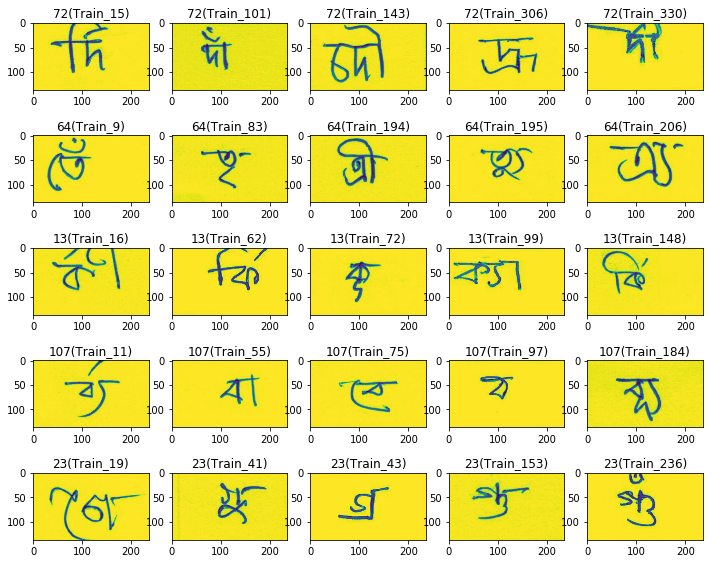

In [13]:
# Top 5 example
disp_img(imageDf, top_roots.index[:5])

### Top used Vowel Diacritic

In [14]:
top_vowels = getTop('vowel_diacritic', 10)
top_vowels

,component,count
0,ং,41508
1,ঃ,36886
7,ঊ,28723
2,অ,25967
4,ই,18848
3,আ,16152
9,এ,16032
5,ঈ,5297
6,উ,4336
10,ঐ,3563


<Figure size 432x288 with 0 Axes>

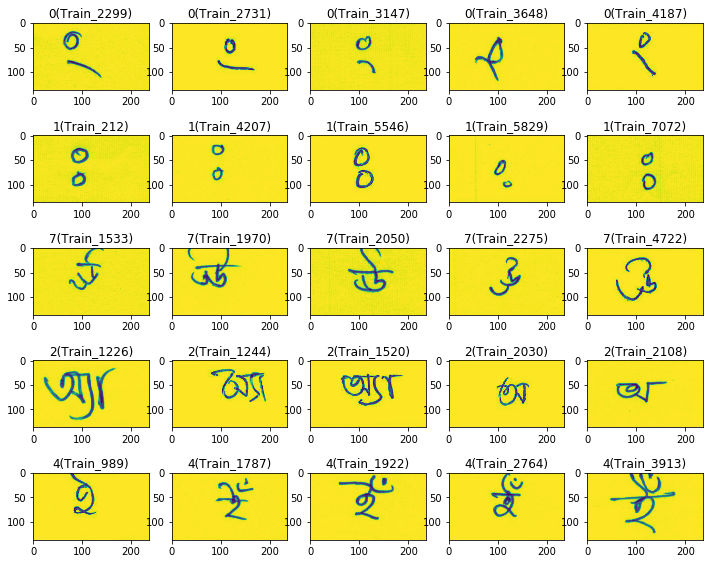

In [15]:
# Top 5 example
disp_img(imageDf, top_vowels.index[:5])

### Top used Consonant Diacritic

In [16]:
top_consonants = getTop('consonant_diacritic', 10)
top_consonants

,component,count
0,ং,125278
2,অ,23465
5,ঈ,21397
4,ই,21270
1,ঃ,7424
6,উ,1387
3,আ,619


<Figure size 432x288 with 0 Axes>

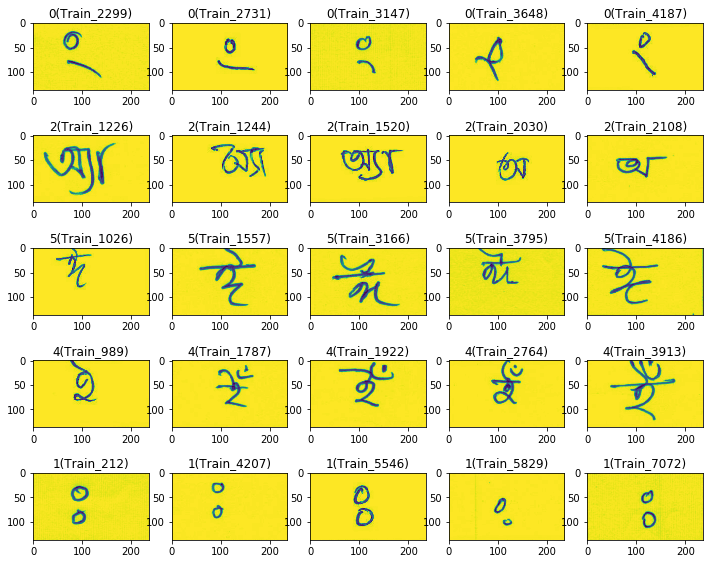

In [17]:
disp_img(imageDf, top_consonants.index[:5])

In [18]:
# target columns
tgt_cols = ['grapheme_root','vowel_diacritic','consonant_diacritic']

In [19]:
desc_df = trainDf[tgt_cols].astype('str').describe()
desc_df

,grapheme_root,vowel_diacritic,consonant_diacritic
count,200840,200840,200840
unique,168,11,7
top,72,0,0
freq,5736,41508,125278


In [20]:
# Number of unique types
types = desc_df.loc['unique',:]
types

grapheme_root          168
vowel_diacritic         11
consonant_diacritic      7
Name: unique, dtype: object

## Task: Building Banglanet Models

In [21]:
SIZE = 64    # input image size
N_ch = 1

In [22]:
def down_block(x, filters, kernel_size=(3,3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation = "relu")(x)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation = "relu")(c)
    c = BatchNormalization(momentum = 0.20)(c)
    p = MaxPool2D(pool_size=(2,2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3,3), padding="same", strides=1):
    us = UpSampling2D((2,2))(x)
    x = Concatenate()([us, skip])
    x = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation = "relu")(x)
    x = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation = "relu")(x)
    return x 

def bottleneck(x, filters, kernel_size=(3,3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation = "relu")(x)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation = "relu")(c)
    return c

def final_classify(x, r=0.3):
    model = Flatten()(x)
    model = Dense(1024, activation = "relu")(model)
    model = Dropout(rate=r)(model)
    dense = Dense(512, activation = "relu")(model)
    return dense
    

In [23]:
def build_banglanet():
    f = [32, 64, 128]
    inputs = Input(shape=(SIZE, SIZE, N_ch))
    
    c1, p1 = down_block(inputs, f[0])
    c2, p2 = down_block(p1, f[1])
    c3, p3 = down_block(p2, f[2])
    
    bn = bottleneck(p3, f[2])
    
    u1 = up_block(bn, c3, f[2])
    u2 = up_block(u1, c2, f[1])
    u3 = up_block(u2, c1, f[0])
    
    dense = final_classify(u3)
    # multi output
    grapheme_root = Dense(types['grapheme_root'],
                          activation = 'softmax', name='root')(dense)
    vowel_diacritic = Dense(types['vowel_diacritic'],
                            activation = 'softmax', name='vowel')(dense)
    consonant_diacritic = Dense(types['consonant_diacritic'],
                                activation = 'softmax', name='consonant')(dense)
    model = Model(inputs=inputs, outputs=[grapheme_root, vowel_diacritic, consonant_diacritic])
    return model
    
    
    
    


In [24]:
model = build_banglanet()

In [25]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 32)   128         conv2d_2[0][0]                   
____________________________________________________________________________________________

In [26]:
# compile
model.compile(Adam(lr=0.002),
              loss={'root': 'categorical_crossentropy',
                    'vowel': 'categorical_crossentropy',
                    'consonant': 'categorical_crossentropy'},
              loss_weights={'root': 0.333,        ## Set weights
                            'vowel': 0.333,
                            'consonant': 0.333},
              metrics={'root': 'accuracy',
                       'vowel': 'accuracy',
                       'consonant': 'accuracy'}
             )


## Training
### Prepare Training Data

In [27]:
# Clip horizontally
def clip(img):
    cols = np.any(img < 200, axis=0)
    xleft, xright = np.where(cols)[0][[0, -1]]
    width = xright - xleft
    center = int((xleft + xright) / 2)
    
    if width < 137:
        img = img[:, max(0, center - 70):min(center + 70, 236)]
    else:
        img = img[:, max(0, xleft - 2):min(xright + 2, 236)]
        
    return img

In [28]:
# Resize image size
def resize(df, size=64):
    resized = {}
    for i in range(df.shape[0]):
        img = clip(df.loc[df.index[i]].values.reshape(137,236))
        image = cv2.resize(img,(size,size))
        resized[df.index[i]] = image.reshape(-1)
    resized_df = pd.DataFrame(resized).T
    return resized_df

In [29]:
# prepare X
imageDf = imageDf.drop(['image_id'], axis = 1)
X_df = (resize(imageDf, SIZE) / 255.).astype('float32')
del imageDf
gc.collect()
for i in tqdm(range(1,4)):
    imageDf = pd.read_parquet(os.path.join(inputPath, 'train_image_data_'+str(i)+'.parquet'))
    imageDf = imageDf.drop(['image_id'], axis = 1)
    imageDf = (resize(imageDf, SIZE) / 255.).astype('float32')
    X_df = pd.concat([X_df, imageDf], axis = 0)
    del imageDf
    gc.collect()
    
X_train = X_df.values.reshape(-1, SIZE, SIZE, N_ch)
del X_df
gc.collect()

3

In [30]:
# prepare Y
trainDf = trainDf[tgt_cols].astype('uint8')
for col in tgt_cols:
    trainDf[col] = trainDf[col].map('{:03}'.format)
Y_train = pd.get_dummies(trainDf)

del trainDf
gc.collect()

0

In [31]:
# Divide the data into train and val set
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)
y_train_root = y_train.iloc[:,0:types['grapheme_root']]
y_train_vowel = y_train.iloc[:,types['grapheme_root']:types['grapheme_root']+types['vowel_diacritic']]
y_train_consonant = y_train.iloc[:,types['grapheme_root']+types['vowel_diacritic']:]
y_test_root = y_test.iloc[:,0:types['grapheme_root']]
y_test_vowel = y_test.iloc[:,types['grapheme_root']:types['grapheme_root']+types['vowel_diacritic']]
y_test_consonant = y_test.iloc[:,types['grapheme_root']+types['vowel_diacritic']:]

del X_train, Y_train
gc.collect()

0

### Fit

In [32]:
batch_size = 128
epochs = 25           ## set epochs

In [33]:
# Callback : Learning Rate annealer
reduceLR = ReduceLROnPlateau(monitor = 'val_root_loss',
                             patience = 2,
                             factor = 0.5,
                             min_lr = 1e-5,
                             verbose = 1)
# Callback : Save best model
chkPoint = ModelCheckpoint('dense.h5',
                           monitor = 'val_root_accuracy',
                           save_best_only = True,
                           save_weights_only = False,
                           mode = 'auto',
                           period = 1,
                           verbose = 0)
# Callback : Early Stop
earlyStop = EarlyStopping(monitor='val_root_accuracy',
                          mode = 'auto',
                          patience = 4,
                          min_delta = 0,
                          verbose = 1)

In [34]:
history = model.fit(x_train,
                    {'root': y_train_root,
                     'vowel': y_train_vowel,
                     'consonant': y_train_consonant},
                    batch_size = batch_size,
                    epochs = epochs,
                    shuffle = True,
                    validation_data = (x_test,
                                       {'root': y_test_root,
                                        'vowel': y_test_vowel,
                                        'consonant': y_test_consonant}),
                    callbacks = [reduceLR, chkPoint, earlyStop],
                    verbose = 1)

del x_train, x_test, y_train, y_test
gc.collect()

Train on 180756 samples, validate on 20084 samples
Epoch 1/25
180756/180756 [==============================] - 210s 1ms/step - loss: 1.5680 - root_loss: 3.2811 - vowel_loss: 0.7247 - consonant_loss: 0.7012 - root_accuracy: 0.2167 - vowel_accuracy: 0.7820 - consonant_accuracy: 0.8194 - val_loss: 0.7326 - val_root_loss: 1.6231 - val_vowel_loss: 0.3388 - val_consonant_loss: 0.2382 - val_root_accuracy: 0.5257 - val_vowel_accuracy: 0.8859 - val_consonant_accuracy: 0.9244
Epoch 2/25
180756/180756 [==============================] - 204s 1ms/step - loss: 0.5915 - root_loss: 1.2610 - vowel_loss: 0.2904 - consonant_loss: 0.2245 - root_accuracy: 0.6303 - vowel_accuracy: 0.9048 - consonant_accuracy: 0.9280 - val_loss: 0.4085 - val_root_loss: 0.8499 - val_vowel_loss: 0.1917 - val_consonant_loss: 0.1853 - val_root_accuracy: 0.7530 - val_vowel_accuracy: 0.9436 - val_consonant_accuracy: 0.9421
Epoch 3/25
180756/180756 [==============================] - 203s 1ms/step - loss: 0.4034 - root_loss: 0.8350 

57

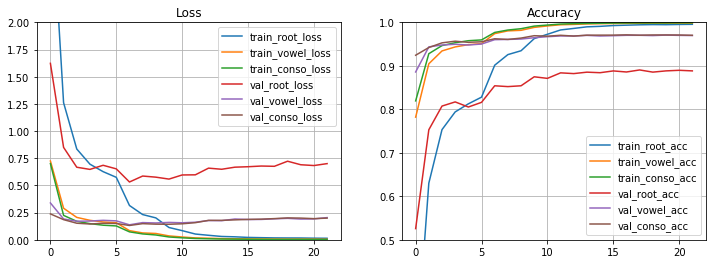

In [35]:

df = pd.DataFrame(history.history)
df.to_csv('hist.csv',index=False)

    
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(df[['root_loss','vowel_loss','consonant_loss','val_root_loss','val_vowel_loss','val_consonant_loss']])
ax[0].set_ylim(0, 2)
ax[0].set_title('Loss')
ax[0].legend(['train_root_loss','train_vowel_loss','train_conso_loss','val_root_loss','val_vowel_loss','val_conso_loss'],loc='upper right')
ax[0].grid()
ax[1].plot(df[['root_accuracy','vowel_accuracy','consonant_accuracy','val_root_accuracy','val_vowel_accuracy','val_consonant_accuracy']])
ax[1].set_ylim(0.5, 1)
ax[1].set_title('Accuracy')
ax[1].legend(['train_root_acc','train_vowel_acc','train_conso_acc','val_root_acc','val_vowel_acc','val_conso_acc'],loc='lower right')
ax[1].grid()

## Predict and Submit

In [36]:
row_ids = []
targets = []      # prediction result
id = 0
for i in range(4):
    img_df = pd.read_parquet(os.path.join(
                            inputPath, 'test_image_data_'+str(i)+'.parquet'))
    img_df = img_df.drop('image_id', axis = 1)
    img_df = resize(img_df, SIZE) / 255.
    X_test = img_df.values.reshape(-1, SIZE, SIZE, N_ch)

    preds = model.predict(X_test)
    for j in range(len(X_test)):
        for k in range(3):
            row_ids.append('Test_'+str(id)+'_'+tgt_cols[k])
            targets.append(np.argmax(preds[k][j]))
        id += 1

In [37]:
submit_df = pd.DataFrame({'row_id':row_ids,'target':targets},
                         columns = ['row_id','target'])
submit_df.head(10)

,row_id,target
0,Test_0_grapheme_root,3
1,Test_0_vowel_diacritic,0
2,Test_0_consonant_diacritic,0
3,Test_1_grapheme_root,61
4,Test_1_vowel_diacritic,2
5,Test_1_consonant_diacritic,0
6,Test_2_grapheme_root,19
7,Test_2_vowel_diacritic,0
8,Test_2_consonant_diacritic,0
9,Test_3_grapheme_root,115


In [38]:
submit_df.to_csv('submission.csv',index=False)